In [390]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from threading import Lock

import os
import re

from typing import Iterable, Optional, List

In [2]:
DATA_ROOT = os.path.abspath("../../data")

In [415]:
class Data:
    
    @staticmethod
    def load(path) -> pd.DataFrame:
        df = pd.read_csv(path, names=["date", "series"])

        # Set Date as Index
        df["date"] = pd.DatetimeIndex(df["date"])
        df = df.set_index("date")

        # Remove Hour Offset, if any
        df.index -= pd.Timedelta(df.index[0].hour, 'h')

        return df
    
    
class Labels:
    
    LABELS_PATH = os.path.join(DATA_ROOT, 'heatwave.csv')
    
    def __init__(self, transform: Optional[pd.DataFrame] = None, binary: bool = False):
        self._transform = transform
        self._binary = binary
        
        self._labels = Data.load(self.LABELS_PATH)
        self._std = float(self._labels.std())
        self._years = np.unique(self.index.year)
        
        if binary:
            self._labels = (self._labels > self._std).astype(np.int)
        
        self._transformed_labels = self._labels - self._transform.values if (self._transform is not None) else self._labels
        
    @property
    def index(self) -> pd.DatetimeIndex:
        return self._labels.index
    
    @property
    def years(self) -> np.ndarray:
        return self._years
    
    @property
    def events(self) -> pd.DataFrame:
        return self._labels > self.std
    
    @property
    def std(self) -> float:
        return self._std
    
    @property
    def transform(self) -> Optional[pd.DataFrame]:
        return self._transform
    
    @property
    def binary(self) -> bool:
        return self._binary
        
    def get(self, transformed=True) -> pd.DataFrame:
        return self._transformed_labels if transformed else self._labels
    
    def plot(self, year: int):
        heatwave = self.get(False)["series"][str(year)]
        
        # Create Big Figure
        plt.rcParams['figure.figsize'] = [15, 5]
        
        # Plot Heatwave
        plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
        plt.plot(heatwave, c="black", label="T95")
        plt.axhline(self.std, c="gray", linestyle="--", label="T95 Mean + STD")
        plt.fill_between(heatwave.index, self.std, heatwave, where=heatwave > self.std,
                         interpolate=True, color="crimson", label="Heat Wave Events")

        plt.xlabel("Date")
        plt.ylabel("Heatwave (STD)")
        plt.ylim(-3, 3)
        plt.legend()

        
class Features:
    STATIC_FEATURE_ROOT = os.path.join(DATA_ROOT, 'features')
    DYNAMIC_FEATURE_ROOT = os.path.join(DATA_ROOT, 'precursor')
    
    def __init__(self, index: pd.DatetimeIndex, precursor: int, selection: Optional[List[str]] = None, dynamic_set: int = 0, normalize=True):
        self._index = index
        self._precursor = precursor
        
        self._selection = selection
        self._dynamic_set = dynamic_set
        
        self._normalize = normalize
        
        self._years = np.unique(self.index.year)
        
        self.static_features = self._load_static_features()
        self.dynamic_features = {year: self._load_dynamic_features(year) for year in self.years}
        
    @property
    def index(self) -> pd.DatetimeIndex:
        return self._index
    
    @property
    def years(self) -> np.ndarray:
        return self._years
    
    @property
    def precursor(self) -> int:
        return self._precursor
    
    def get(self, year: int) -> pd.DataFrame:
        return pd.concat([self.static_features, self.dynamic_features[year]], axis=1)
        
    def _load_static_features(self) -> pd.DataFrame:
        features = pd.DataFrame(index=self.index)
        
        for path in os.listdir(self.STATIC_FEATURE_ROOT):
            name, ext = os.path.splitext(path)
            
            if ext == '.csv':
                if not self._selection or name in self._selection:
                    feature = Data.load(os.path.join(self.STATIC_FEATURE_ROOT, path))
                    
                    if self._selection:
                        
                        windows, lags = self._selection[name]
                        
                        for window, lag in zip(windows, lags):
                            features[f"{name}-{window}-{lag}"] = feature.rolling(window).mean().loc[self.index - pd.Timedelta(lag, 'D')].values
                    else:
                        features[name] = feature.loc[self.index].values
                        
        if self._normalize:
            for column in features.columns:
                features[column] = (features[column] - features[column].mean()) / features[column].std()
                
        return features.astype(np.float64)
    
    def _load_dynamic_features(self, year) -> pd.DataFrame:
        features = pd.DataFrame(index=self.index)
        
        df = pd.read_csv(os.path.join(self.DYNAMIC_FEATURE_ROOT,
                                      str(self._dynamic_set),
                                      f'testyr[{year}]_{self.precursor}.csv'))
        
        # Set Date as Index
        df['date'] = pd.DatetimeIndex(df['date'])
        df = df.set_index('date')
        
        # Remove Hour Offset, if any
        df.index -= pd.Timedelta(df.index[0].hour, 'h')
        
        if self._selection:
            df = df[[column for column in self._selection if column in df]]
            
            for column in df.columns:
                
                windows, lags = self._selection[column]
                
                for window, lag in zip(windows, lags):
                    features[f"{column}-{window}-{lag}"] = df[column].rolling(window).mean().loc[self.index - pd.Timedelta(lag, 'D')].values
        else:
            for column in df.columns:
                features[column] = df[column].loc[self.index]
        
        if self._normalize:
            for column in features.columns:
                features[column] = (features[column] - features[column].mean()) / features[column].std()
            
        return features.astype(np.float64)
    
    def __repr__(self):
        return f"{self.__class__.__name__}(precursor: {self.precursor})"

In [4]:
class Correlation:
    def __init__(self, labels: Labels, precursor: int, max_lag: int):
        self._labels = labels
        self._precursor = precursor
        self._max_lag = max_lag
        
        self._index = self._calculate_extended_index()
        self._features = Features(self.index, precursor)
        
    @property
    def labels(self) -> Labels:
        return self._labels
    
    @property
    def features(self) -> Features:
        return self._features
    
    @property
    def index(self) -> pd.DatetimeIndex:
        return self._index
    
    @property
    def years(self) -> np.ndarray:
        return self.labels.years
    
    @property
    def max_lag(self) -> int:
        return self._max_lag
    
    def get_year(self, year: int):
        label = self.labels.get().values.ravel()
        
        correlation = {}
        
        for column in self.features.get(year).columns:
            
            correlation[column] = []
            
            for lag in range(self.max_lag):
                feature = self.features.get(year)[column][self.labels.index - pd.Timedelta(lag, 'D')].values.ravel()
                correlation[column].append(np.corrcoef(label, feature)[0, 1])
            correlation[column] = np.array(correlation[column])
        
        return correlation
    
    def get(self, threads: int = 4):
        
        correlations = {}
        
        with ProcessPoolExecutor(threads) as ex:
            for future in [ex.submit(self.get_year, year) for year in self.years]:
                for key, data in future.result().items():
                    if key not in correlations:
                        correlations[key] = []
                    correlations[key].append(data)
                    
        return correlations
    
    @staticmethod
    def plot(correlations):
        mean_std = {}
        
        for key, data in correlations.items():
            mean_std[key] = {'mean': np.mean(data, 0), 'std': np.std(data, 0)}
            
        plt.rcParams['figure.figsize'] = [25, 10]

        linestyles = ['-', '--', '-.', ':']
        for i, (color, (key, data)) in enumerate(zip(cm.rainbow(np.linspace(0, 1, len(mean_std))), mean_std.items())):

            mean = np.abs(data['mean'])
            std = data['std']

            plt.fill_between(range(len(mean)), mean-std, mean+std, zorder=-10, color=color, alpha=0.2)
            plt.plot(mean, color=color, label=key, ls=linestyles[i%len(linestyles)])

        plt.legend()
        plt.show()
              
    def _calculate_extended_index(self):
        return pd.DatetimeIndex(pd.concat([pd.DataFrame(pd.date_range(
            self.labels.get()[str(year)].index[0] - pd.Timedelta(self.max_lag, "D"),
            self.labels.get()[str(year)].index[-1]
        )) for year in self.labels.years])[0], name="date")

In [5]:
class TrainTestData:
    def __init__(self, X, y):
        self._X = X
        self._y = y
    
    @property
    def X(self) -> pd.DataFrame:
        return self._X
    
    @property
    def y(self) -> pd.DataFrame:
        return self._y
    

class TrainTestSplit:
    def __init__(self, features: Features, labels: Labels, balance: float = 0):
        self._features = features
        self._labels = labels
        
        self._train = {}
        self._test = {}
        
        for test_year in labels.years:
            
            # Split Features and Labels based on Test Year
            train_X = pd.concat([features.get(test_year)[str(year)] for year in labels.years if year != test_year])
            train_y = pd.concat([labels.get()[str(year)] for year in labels.years if year != test_year])
            
            test_X = features.get(test_year)[str(test_year)]
            test_y = labels.get()[str(test_year)]
    
            if balance:
            
                events = pd.concat([labels.events[str(year)] for year in labels.years if year != test_year])

                # Balance Dataset
                pos = np.where(events)[0]
                neg = np.where(~events)[0]
                
                idx = np.random.permutation(np.concatenate([pos, np.random.choice(neg, int(len(pos)/balance), False)]))
                train_X, train_y = train_X.iloc[idx], train_y.iloc[idx]
                
            # Add to Dictionary
            self._train[test_year] = TrainTestData(train_X, train_y)
            self._test[test_year] = TrainTestData(test_X, test_y)
            
    @property
    def features(self) -> Features:
        return self._features
    
    @property
    def labels(self) -> Labels:
        return self._labels
    
    def train(self, year) -> TrainTestData:
        return self._train[year]
    
    def test(self, year) -> TrainTestData:
        return self._test[year]

In [455]:
class Predictor:
    def __init__(self, split: TrainTestSplit, threads: int = 4):
        self._split = split
        
        self._predictions = pd.DataFrame(index=self.split.labels.index, columns=["values"])
        
        with ThreadPoolExecutor(threads) as ex:
            for year, future in [(year, ex.submit(self.predict, year)) for year in self.split.labels.years]:
                self._predictions["values"][str(year)] = future.result()
                
        if split.labels.transform is not None:
            self._predictions += split.labels.transform.values
                
    @property
    def split(self) -> TrainTestSplit:
        return self._split
    
    @property
    def predictions(self) -> pd.DataFrame:
        return self._predictions
    
    @property
    def auc(self) -> float:
        return roc_auc_score(self.split.labels.get(False) if self.split.labels.binary else self.split.labels.get(False) > self.split.labels.std, self.predictions)
    
    @property
    def mse(self) -> float:
        return mean_squared_error(self.split.labels.get(False), self.predictions)
    
    @property
    def rmse(self) -> float:
        return np.sqrt(self.mse)
    
    def predict(self, year: int, offset: Optional[pd.DataFrame]) -> pd.DataFrame:
        raise NotImplementedError()
        
    def plot(self, year: int, label: str = None):
        plt.plot((self.predictions[str(year)] - self.predictions.mean()) / self.predictions.std(), label=label if label else self.__class__.__name__)
        
    def plot_roc(self):
        # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
        fpr, tpr, thr = roc_curve(self.split.labels.get(False) if self.split.labels.binary else self.split.labels.get(False) > self.split.labels.std, self.predictions)
        auc = roc_auc_score(self.split.labels.get(False) if self.split.labels.binary else self.split.labels.get(False) > self.split.labels.std, self.predictions)

        plt.title(f"ROC Curve - AUC: {auc:5.5f}")
        plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
        plt.plot(fpr, tpr)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel("False Positive Ratio")
        plt.ylabel("True Positive Ratio")
        
        
class SpatialCovariancePredictor(Predictor):
    def predict(self, year: int):
        return self.split.test(year).X["spatcov_CPPA"].values
    

class SKPredictor(Predictor):
    def __init__(self, split: TrainTestSplit, regressor, **kwargs):
        self._kwargs = kwargs
        self._regressor = regressor
        self._regressors = {}
        super().__init__(split)
        
    def predict(self, year: int):
        # Create Gradient Boosting Regressor
        regressor = self._regressor(**self._kwargs)
        
        # Obtain Train Set
        train_X = self.split.train(year).X
        train_y = self.split.train(year).y.values.ravel()
        
        # Fit Regressor to Train Data
        regressor.fit(train_X, train_y)
        
        # Obtain Test Features
        test_X = self.split.test(year).X
        
        # Add Regressor to Dictionary
        self._regressors[year] = regressor
        
        # Return Prediction for Test Year
        return regressor.predict(test_X)
    
    def plot_importances(self):
        
        feature_importances = {}
        
        for year, regressor in self._regressors.items():
            for name, importance in zip(self.split.train(year).X.columns, regressor.feature_importances_):
                if name not in feature_importances:
                    feature_importances[name] = [0, 0]
                feature_importances[name][0] += importance
                feature_importances[name][1] += 1

        names, importances = [], []

        for name, (importance, count) in feature_importances.items():
            names.append(name)
            importances.append(float(importance) / float(count))

        importances = np.array(importances) / np.sum(importances)
        order = np.argsort(importances)

        plt.title(f"Relative Feature Importances")
        plt.barh(np.arange(len(names)), importances[order], tick_label=[names[index] for index in order])
        
        return np.cumsum(importances[order]), [names[index] for index in order[::-1]]
        
    def plot_deviance(self):
        
        train_scores = []
        test_scores = []
        
        for year in self.split.labels.years:
            
            test_X = self.split.test(year).X
            test_y = self.split.test(year).y.values.ravel()
            
            train_scores.append(self._regressors[year].train_score_)
            test_scores.append([mean_squared_error(p, test_y) for p in self._regressors[year].staged_predict(test_X)])
        
        train_scores = np.mean(train_scores, 0)
        test_scores = np.mean(test_scores, 0)
        
        plt.title(f"Gradient Boosting Regressor Performance over Iterations")
        plt.plot(train_scores, label="Training Set Deviance")
        plt.plot(test_scores, label="Test Set Deviance")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance (MSE)")
        plt.legend()
        
        return np.argmin(test_scores)


class GradientBoostingPredictor(Predictor):
    def __init__(self, split: TrainTestSplit, **kwargs):
        self._kwargs = kwargs
        self._regressors = {}
        super().__init__(split)
    
    def predict(self, year: int):
        # Create Gradient Boosting Regressor
        regressor = GradientBoostingRegressor(**self._kwargs)
        
        # Obtain Train Set
        train_X = self.split.train(year).X
        train_y = self.split.train(year).y.values.ravel()
        
        # Fit Regressor to Train Data
        regressor.fit(train_X, train_y)
        
        # Obtain Test Features
        test_X = self.split.test(year).X
        
        # Add Regressor to Dictionary
        self._regressors[year] = regressor
        
        # Return Prediction for Test Year
        return regressor.predict(test_X)
    
    def plot_importances(self):
        
        feature_importances = {}
        
        for year, regressor in self._regressors.items():
            for name, importance in zip(self.split.train(year).X.columns, regressor.feature_importances_):
                if name not in feature_importances:
                    feature_importances[name] = [0, 0]
                feature_importances[name][0] += importance
                feature_importances[name][1] += 1

        names, importances = [], []

        for name, (importance, count) in feature_importances.items():
            names.append(name)
            importances.append(float(importance) / float(count))

        importances = np.array(importances) / np.sum(importances)
        order = np.argsort(importances)

        plt.title(f"Relative Feature Importances")
        plt.barh(np.arange(len(names)), importances[order], tick_label=[names[index] for index in order])
        
        return np.cumsum(importances[order]), [names[index] for index in order[::-1]]
        
    def plot_deviance(self):
        
        train_scores = []
        test_scores = []
        
        for year in self.split.labels.years:
            
            test_X = self.split.test(year).X
            test_y = self.split.test(year).y.values.ravel()
            
            train_scores.append(self._regressors[year].train_score_)
            test_scores.append([mean_squared_error(p, test_y) for p in self._regressors[year].staged_predict(test_X)])
        
        train_scores = np.mean(train_scores, 0)
        test_scores = np.mean(test_scores, 0)
        
        plt.title(f"Gradient Boosting Regressor Performance over Iterations")
        plt.plot(train_scores, label="Training Set Deviance")
        plt.plot(test_scores, label="Test Set Deviance")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance (MSE)")
        plt.legend()
        
        return np.argmin(test_scores)
        
        
class NNPredictor(Predictor):
    def __init__(self, split: TrainTestSplit, **kwargs):
        self._kwargs = kwargs
        super().__init__(split)
        
    def predict(self, year: int):
        # Create Muiltilayer Perceptron Regressor
        regressor = MLPRegressor(**self._kwargs)
        
        # Obtain Train Set
        train_X = self.split.train(year).X
        train_y = self.split.train(year).y.values.ravel()
        
        # Fit Regressor to Train Data
        regressor.fit(train_X, train_y)
        
        # Obtain Test Features
        test_X = self.split.test(year).X
        
        # Return Prediction for Test Year
        return regressor.predict(test_X)

# Experimentation

In [7]:
PRECURSOR = 50
LAG = 50
SET = 2

# Fourier Analysis

/Users/bram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:121: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/bram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:153: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


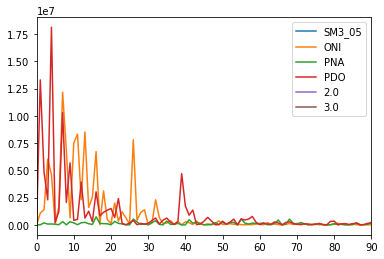

In [8]:
features = Features(pd.date_range("1979-01-01", "2017-12-31"), precursor=PRECURSOR, dynamic_set=SET)

data = features.get(2012).interpolate()

plt.xlim(0, 90)

for column in ['SM3_05', 'ONI', 'PNA', 'PDO', '2.0', '3.0']:
    
    power = np.abs(np.fft.fft(data[column])) ** 2
    
    plt.plot(power, label=column)
    
plt.legend()
plt.show()

# Spatial Covariance

In [257]:
labels = Labels()

features_spatcov = Features(labels.index - pd.Timedelta(LAG, 'D'), precursor=PRECURSOR, dynamic_set=SET, selection={"spatcov_CPPA": (1, None)})
split_spatcov = TrainTestSplit(features_spatcov, labels)

predictor_spatcov = SpatialCovariancePredictor(split_spatcov)

print(f"AUC {predictor_spatcov.auc}, MSE {predictor_spatcov.mse}")

AUC 0.6530459461292459, MSE 1.4016748708258213


## Gradient Boosting Regressor (Transformed Labels)

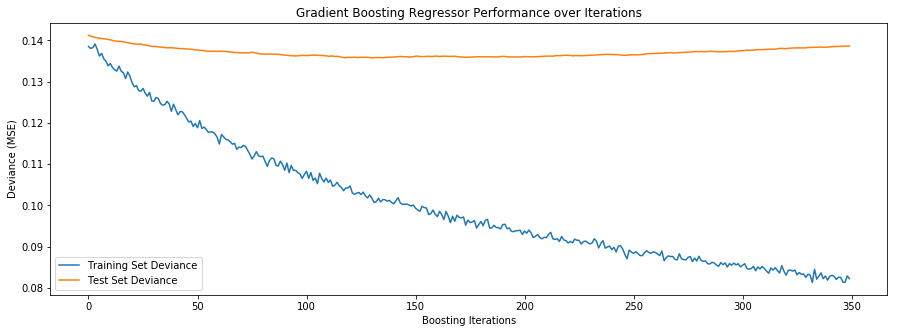

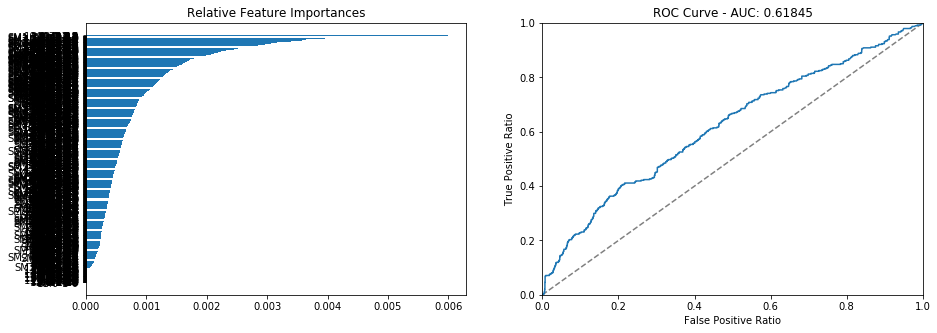

0: (1260) AUC 0.6184494029142169, MSE 0.13537376983058735


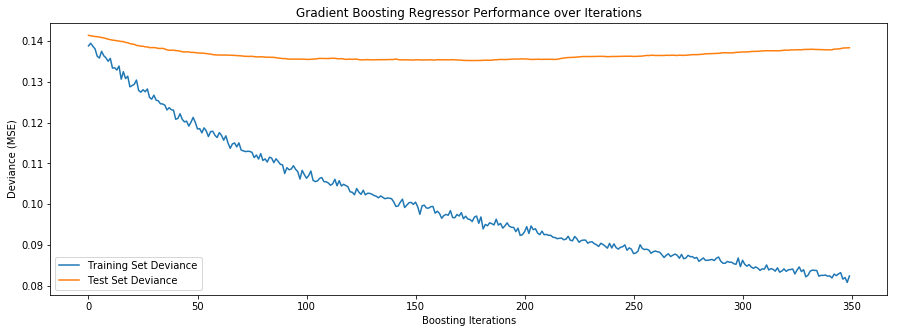

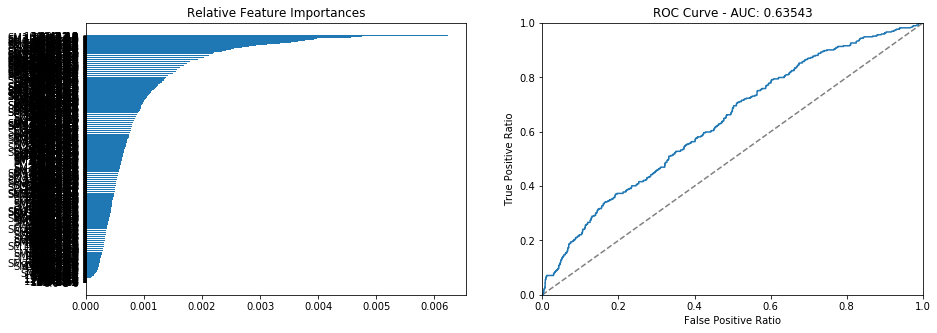

1: (1110) AUC 0.6354326980764917, MSE 0.13540147323021154


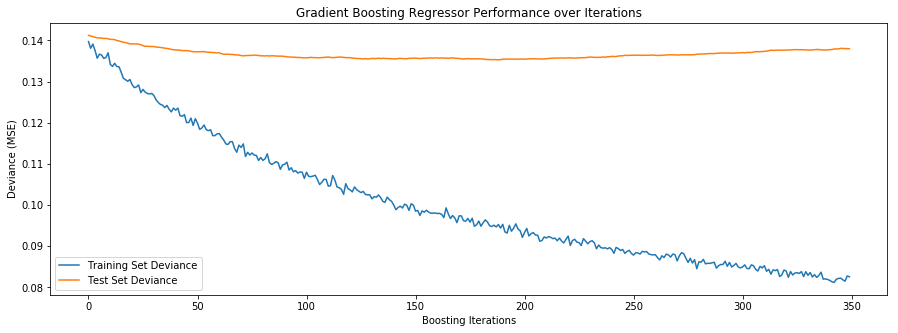

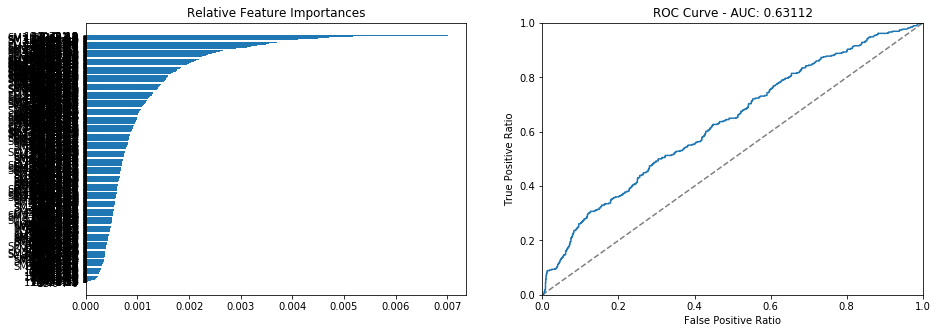

2: (959) AUC 0.6311169338640763, MSE 0.13572274388688357


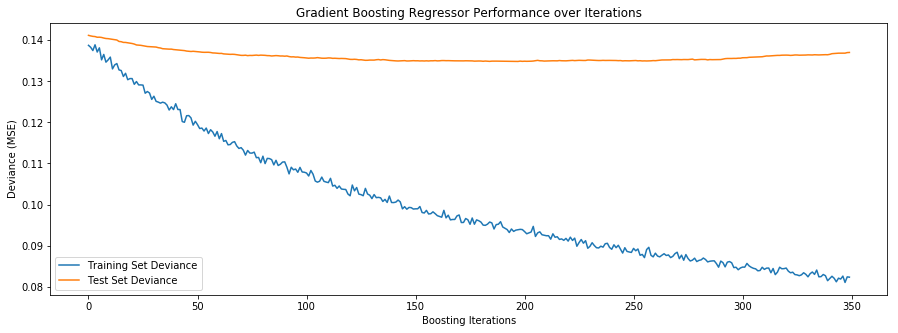

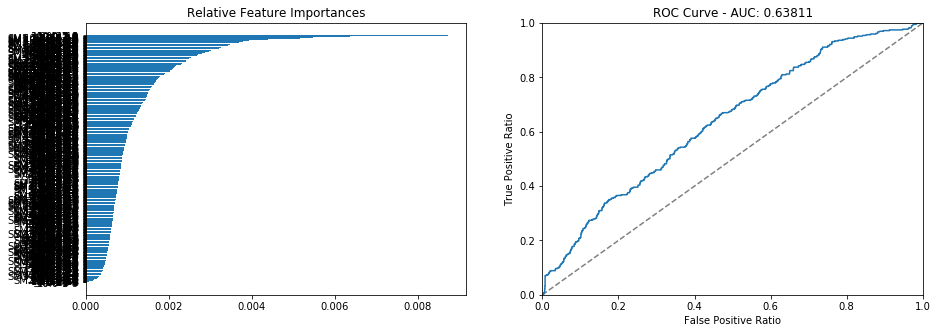

3: (818) AUC 0.6381090196733115, MSE 0.1357355376166404


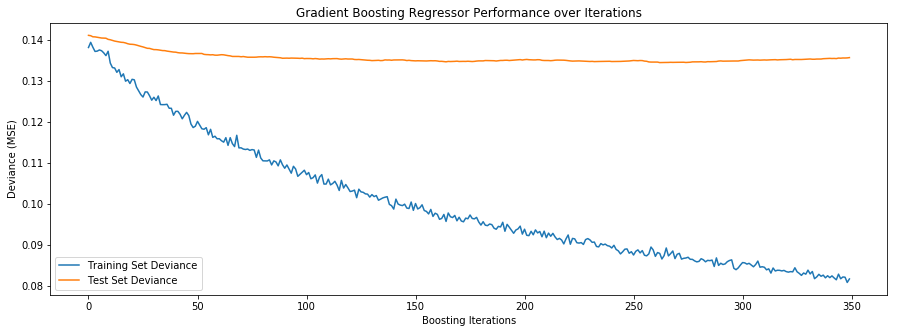

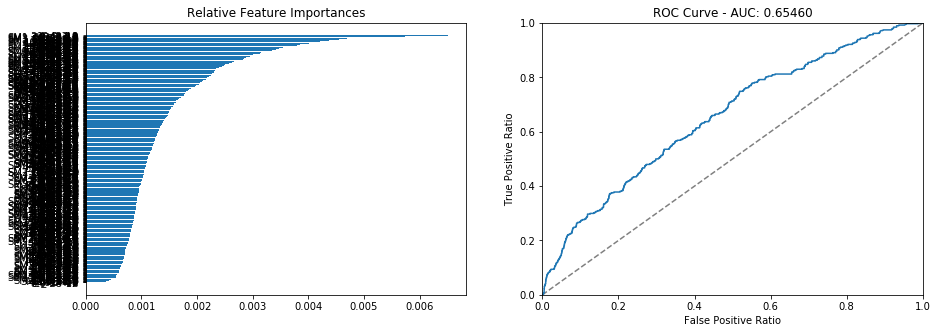

4: (687) AUC 0.6545973518502094, MSE 0.13405032521753715


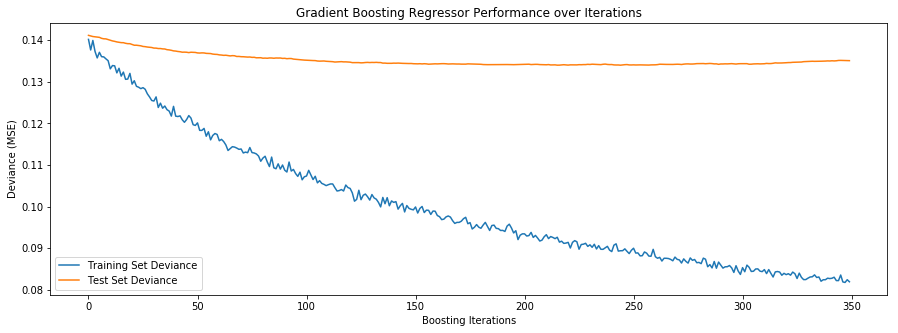

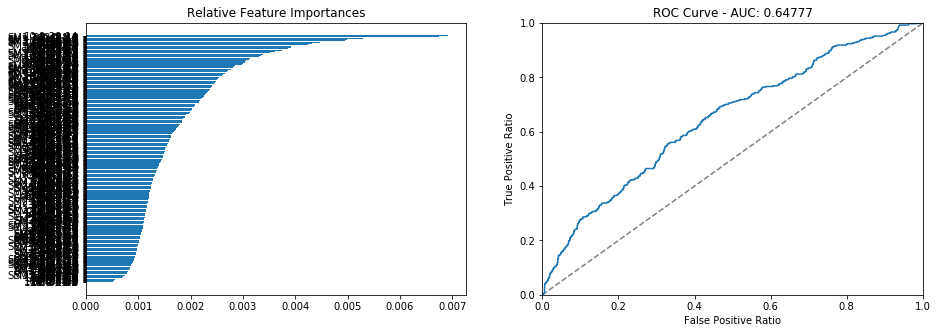

5: (558) AUC 0.6477702537027665, MSE 0.13445153582484606


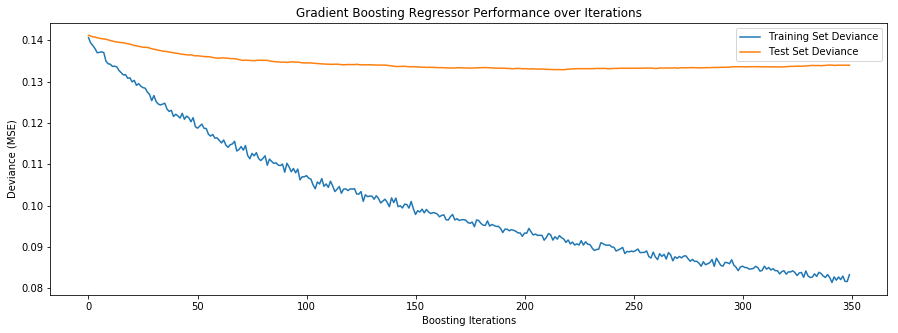

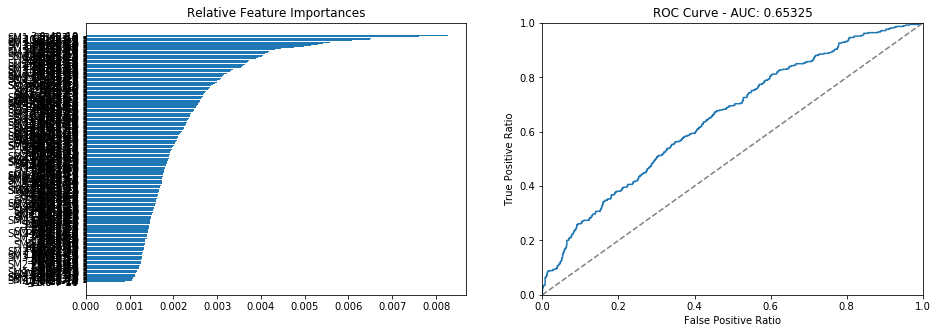

6: (439) AUC 0.6532539740506362, MSE 0.13386887792578553


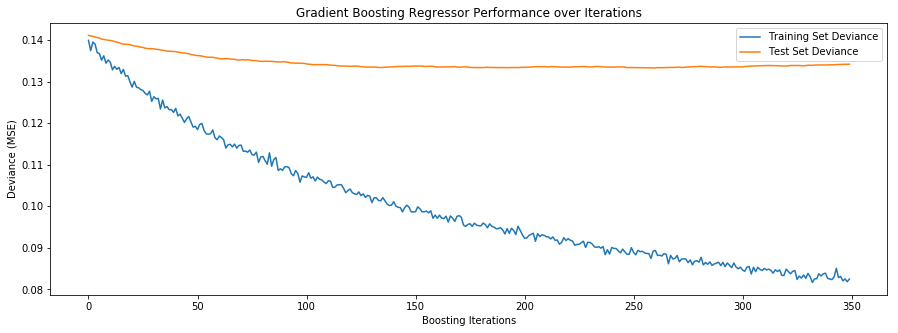

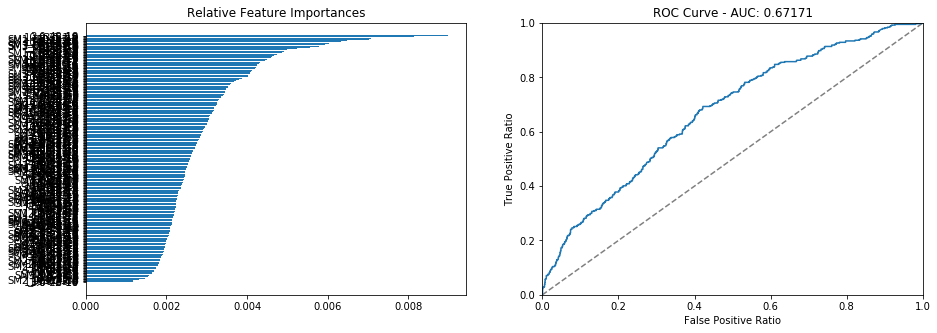

7: (340) AUC 0.6717091156661329, MSE 0.1326063097493161


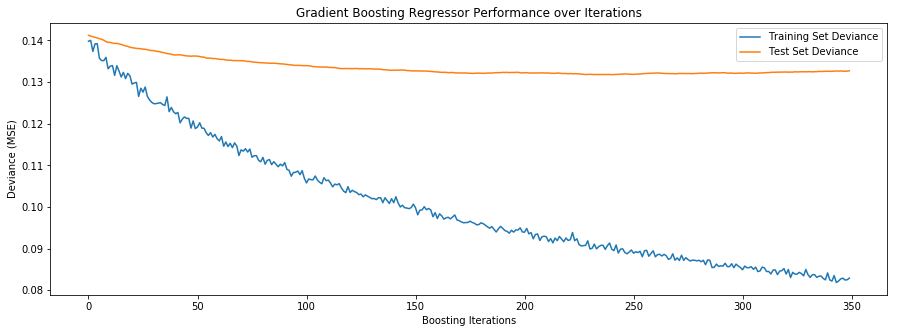

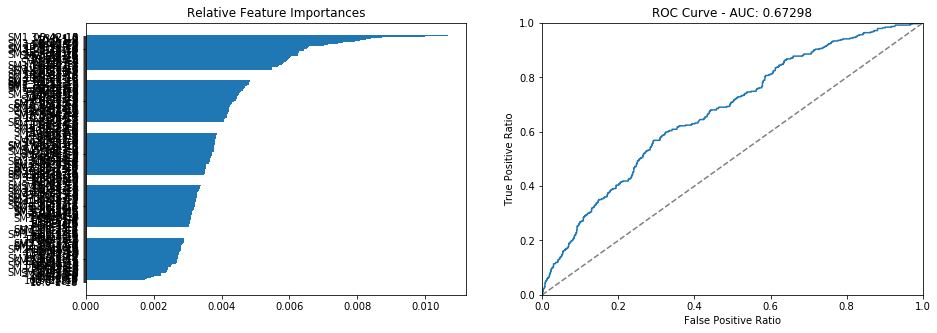

8: (252) AUC 0.6729820639500002, MSE 0.13317234285813845


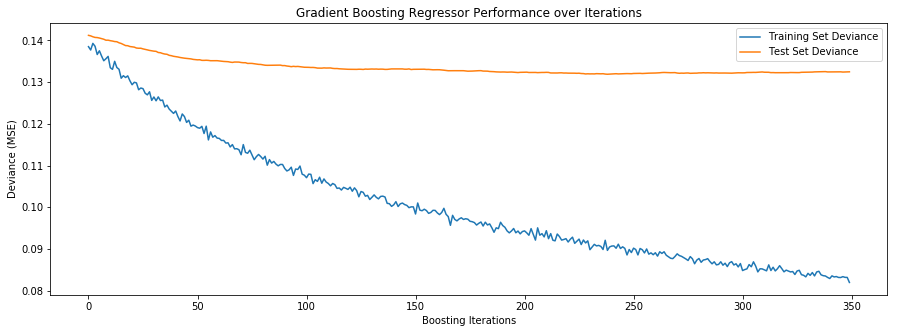

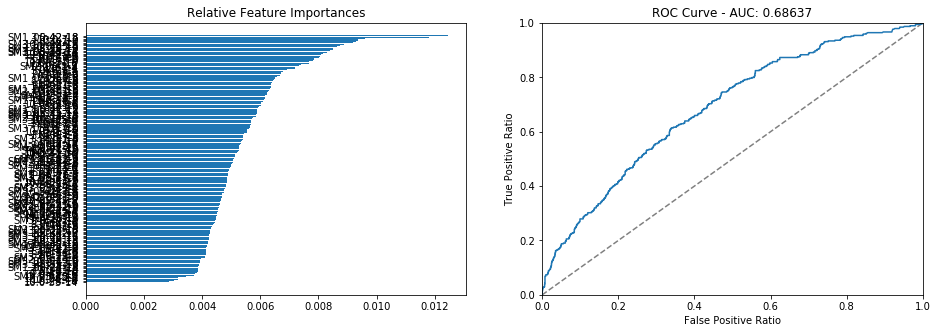

9: (182) AUC 0.6863656283095352, MSE 0.13117739644652243


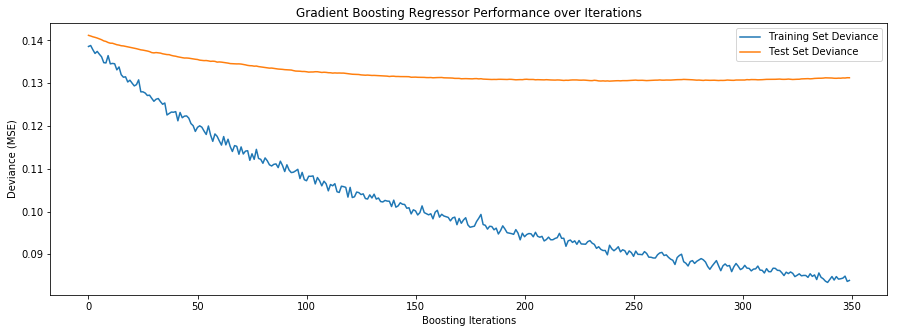

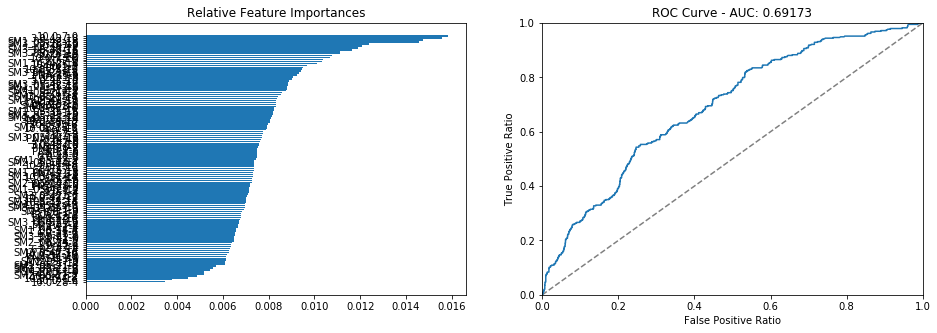

10: (127) AUC 0.6917260970049197, MSE 0.13131389990637443


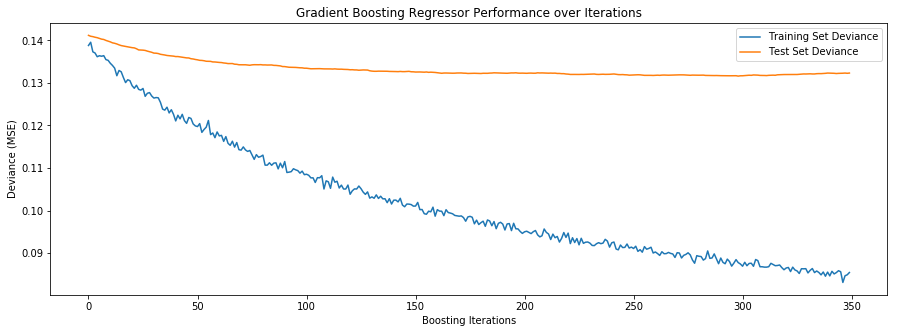

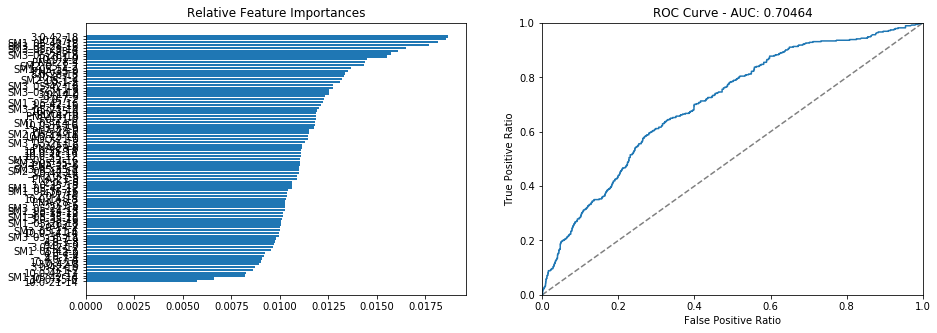

11: (87) AUC 0.704642739760331, MSE 0.13012654221147324


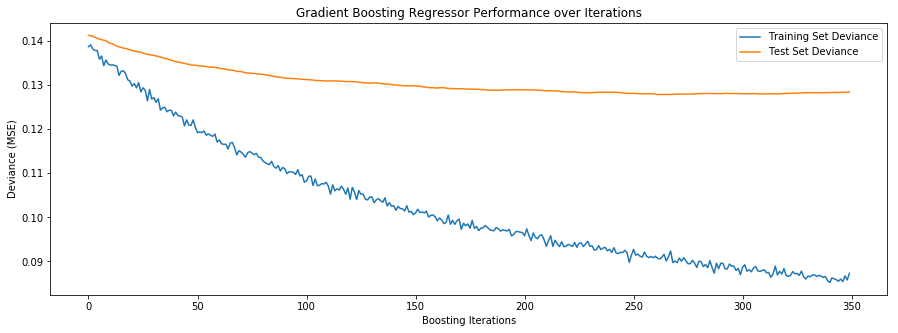

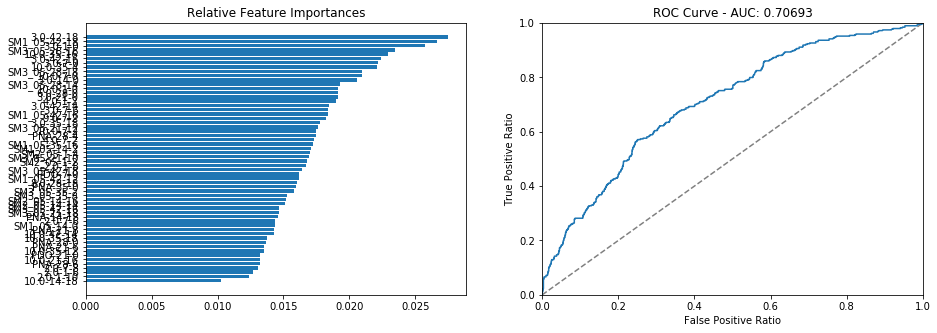

12: (58) AUC 0.7069336553962051, MSE 0.12860574561586155


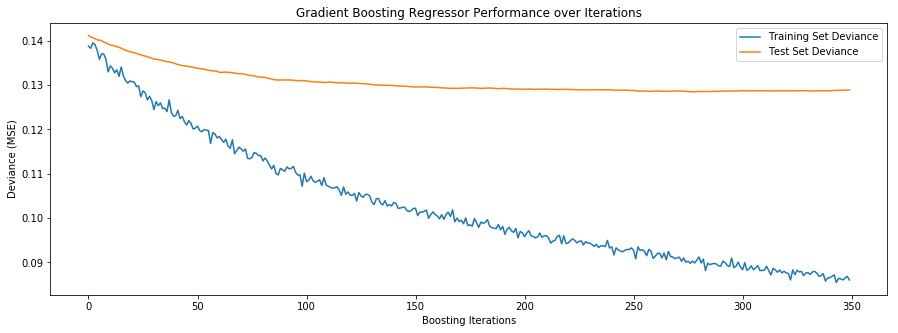

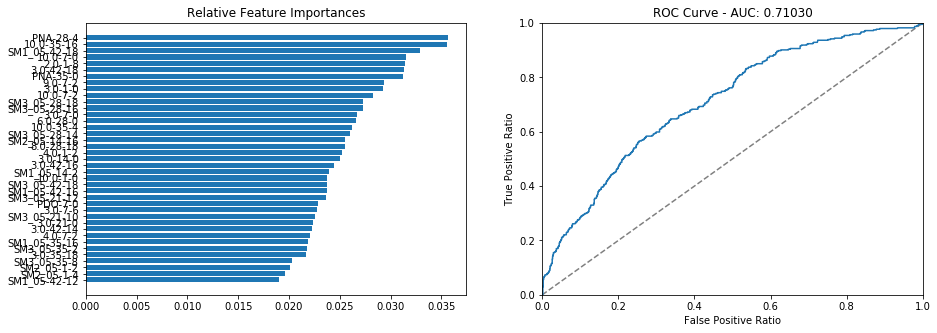

13: (39) AUC 0.7102966647711562, MSE 0.1284919432810306


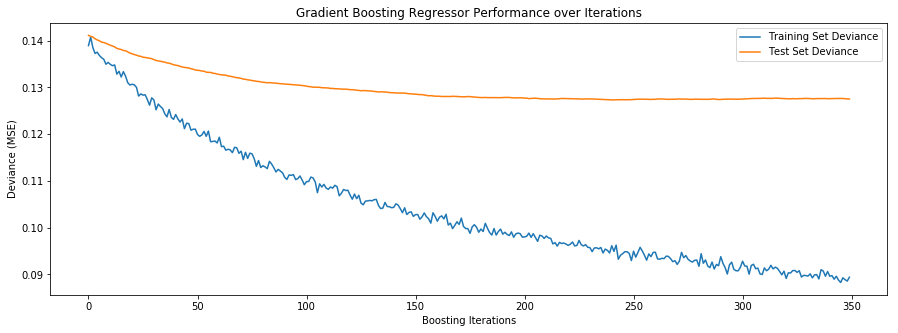

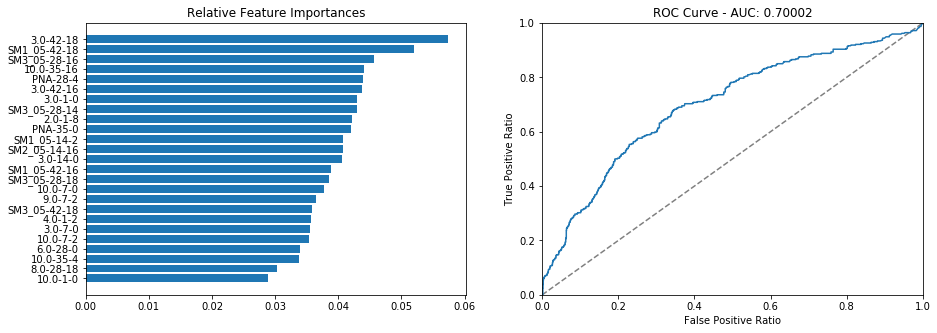

14: (25) AUC 0.7000217809798572, MSE 0.12810814858544878


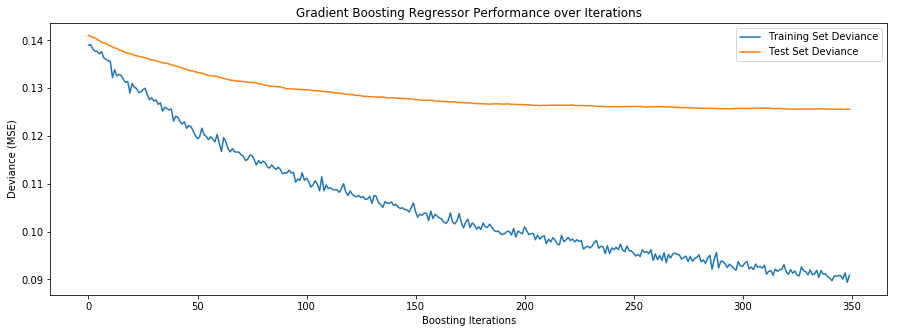

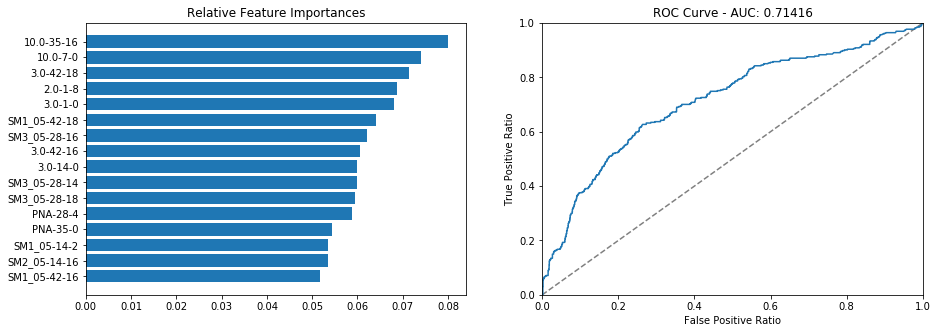

15: (16) AUC 0.7141598541326474, MSE 0.1255344836273596


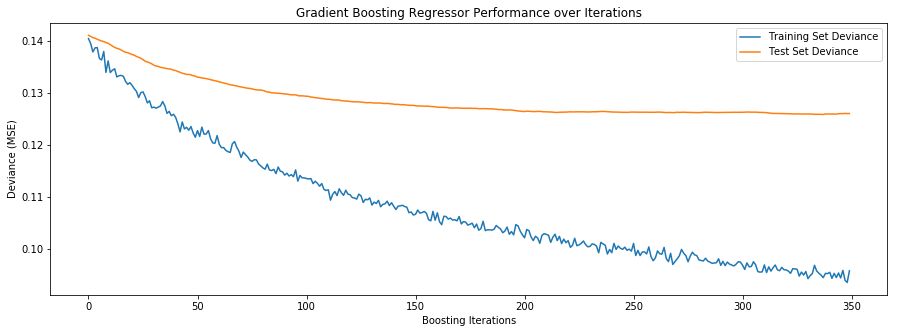

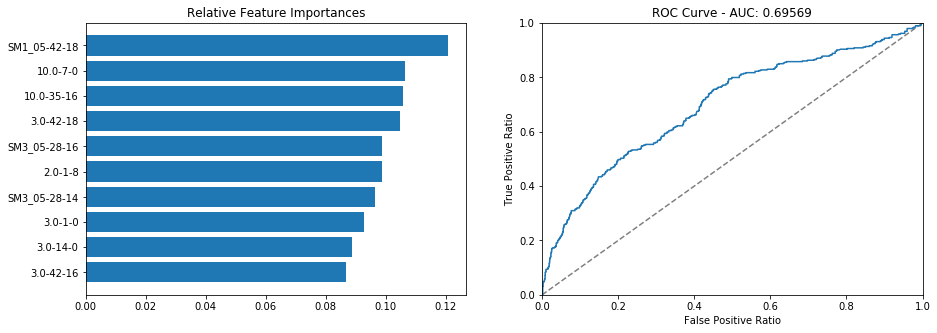

16: (10) AUC 0.6956851487627883, MSE 0.12736125597617778


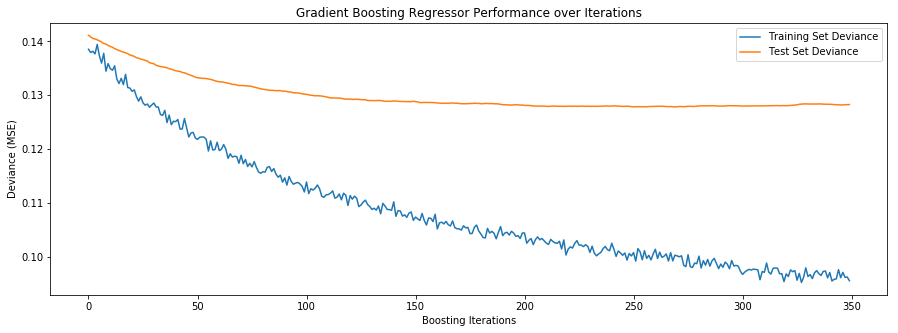

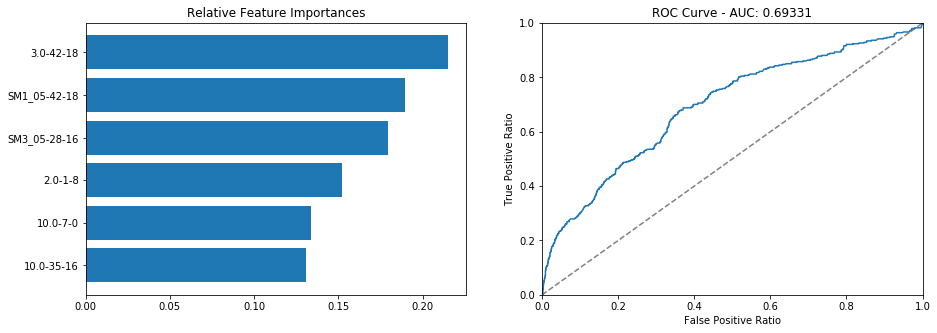

17: (6) AUC 0.6933075004825726, MSE 0.12774186272442495


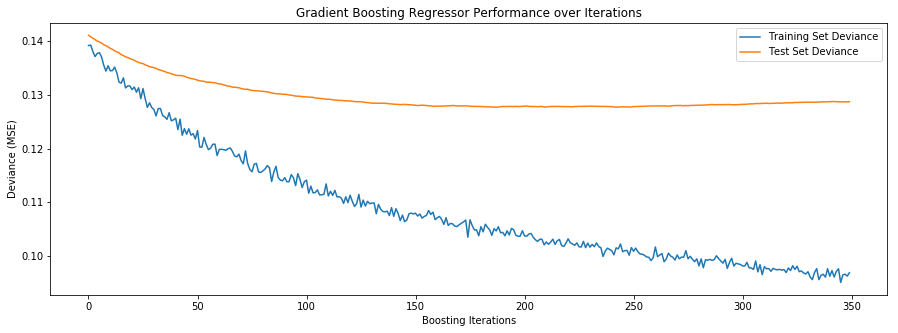

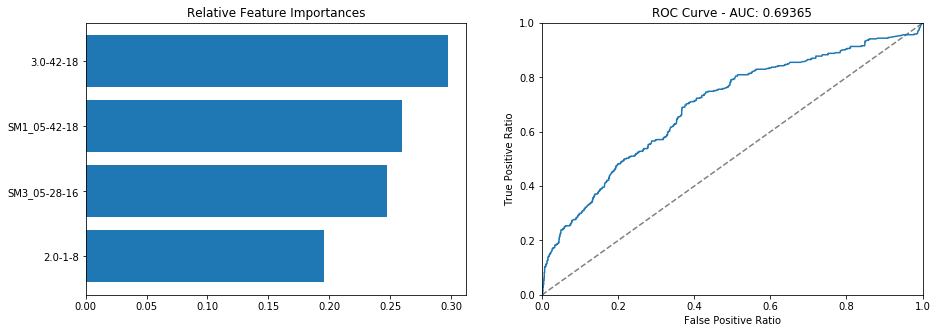

18: (4) AUC 0.6936505183090655, MSE 0.12712618365763462


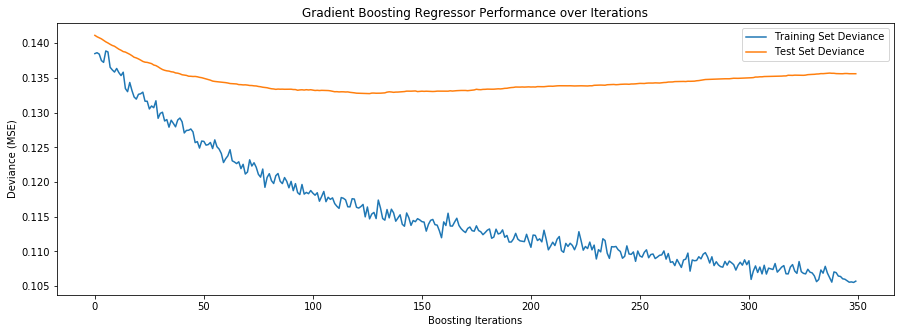

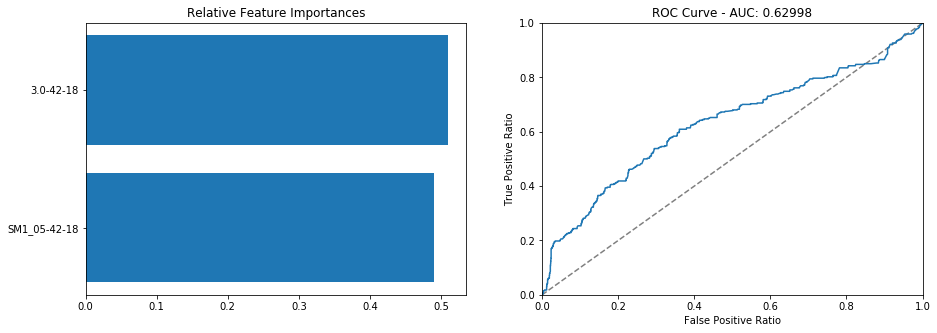

19: (2) AUC 0.6299789754853116, MSE 0.132544083338062


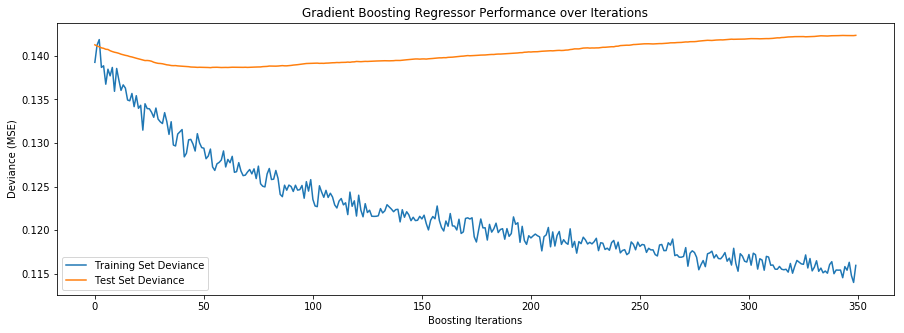

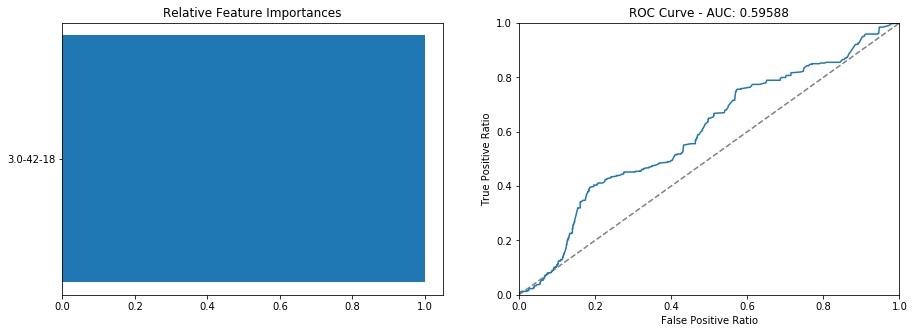

20: (1) AUC 0.59587869950595, MSE 0.13863275188292318


In [440]:
# labels = Labels() # Bare Labels
labels = Labels(binary=True)  # Binary Labels
# labels = Labels(transform=predictor_spatcov.predictions)  # Transformed Labels

# Feature Selection
selection = { key: ([1]*10 + [7]*10 + [14]*10 + [21]*10 + [28]*10 + [35]*10 + [42]*10, list(range(0, 20, 2))*7) for key in [
    'SM3_05',
    'SM2_05',
    'SM1_05',
    'PNA',
    'ONI',
    'PDO',
    'TV',
    '1.0',
    '2.0',
    '3.0',
    '4.0',
    '5.0',
    '6.0',
    '7.0',
    '8.0',
    '9.0',
    '10.0',
    '11.0',
    '12.0'
]}

MAX_DEPTH = 3
MAX_ESTIMATORS = 350
LEARNING_RATE = 0.01
MAX_FEATURES = 'sqrt'
SUBSAMPLE = 0.5
CUTOFF = 0.6

i = 0

while selection:

    # Load Features
    features = Features(labels.index - pd.Timedelta(LAG, 'D'), precursor=PRECURSOR, dynamic_set=SET, selection=selection)

    # Perform Train/Test Split
    split = TrainTestSplit(features, labels, 0)

    # Machine Learning (to obtain optimal #estimators)
    predictor_gbmt = GradientBoostingPredictor(split, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE, n_estimators=MAX_ESTIMATORS, max_features=MAX_FEATURES, subsample=SUBSAMPLE)

    # Optimal Estimators
    optimal_n_estimators = predictor_gbmt.plot_deviance()
    plt.show()

    # Machine Learning (using optimal #estimators)
    predictor_gbmt = GradientBoostingPredictor(split, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE, n_estimators=optimal_n_estimators, max_features=MAX_FEATURES, subsample=SUBSAMPLE)

    # Plot Importances & ROC Curve
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.subplot(121);
    importances_cumsum, importances = predictor_gbmt.plot_importances()
    plt.subplot(122);
    predictor_gbmt.plot_roc()
    plt.show()

    print(f"{i}: ({len(importances)}) AUC {predictor_gbmt.auc}, MSE {predictor_gbmt.mse}")
    
    # Update Feature Selection by Throwing out Weak Features
    selection = {}
    
    # Remove Last CUTOFF percent Features
    cutoff = np.argwhere(importances_cumsum > CUTOFF)
    
    if len(cutoff) == 0: break

    for importance in importances[:cutoff[0][0]]:
        name, window, lag = importance.split('-')
    
        if name not in selection:
            selection[name] = ([], [])

        selection[name][0].append(int(window))
        selection[name][1].append(int(lag))
        
    i += 1

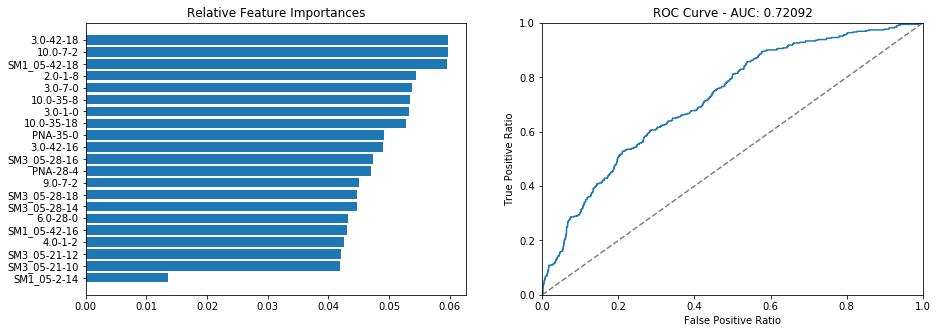

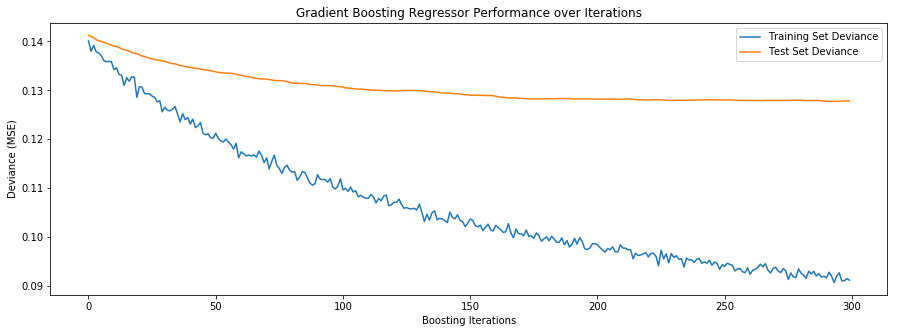

In [456]:
# Finalize Feature Selection

selection = {
    "2.0": ([1], [8]),
    "3.0": ([1, 7, 42, 42], [0, 0, 16, 18]),
    "4.0": ([1], [2]),
    "6.0": ([28], [0]),
    "9.0": ([7], [2]),
    "10.0": ([7, 35, 35], [2, 8, 18]),
    "SM1_05": ([2, 42, 42], [14, 16, 18]),
    "SM3_05": ([21, 21, 28, 28, 28], [10, 12, 14, 16, 18]),
    "PNA": ([28, 35], [4, 0]),
}

# Load Labels
labels = Labels(binary=True)

# Load Features
features = Features(labels.index - pd.Timedelta(LAG, 'D'), precursor=PRECURSOR, dynamic_set=SET, selection=selection)

# Perform Train/Test Split
split = TrainTestSplit(features, labels, 0)

# Machine Learning (using optimal #estimators)
predictor_gbmt = GradientBoostingPredictor(split, max_depth=MAX_DEPTH, learning_rate=0.01, n_estimators=300, max_features=MAX_FEATURES, subsample=SUBSAMPLE)

# Plot Importances & ROC Curve
plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(121);
importances_cumsum, importances = predictor_gbmt.plot_importances()
plt.subplot(122);
predictor_gbmt.plot_roc()
plt.show()

# Optimal Estimators
optimal_n_estimators = predictor_gbmt.plot_deviance()
plt.show()

# Visual Analysis

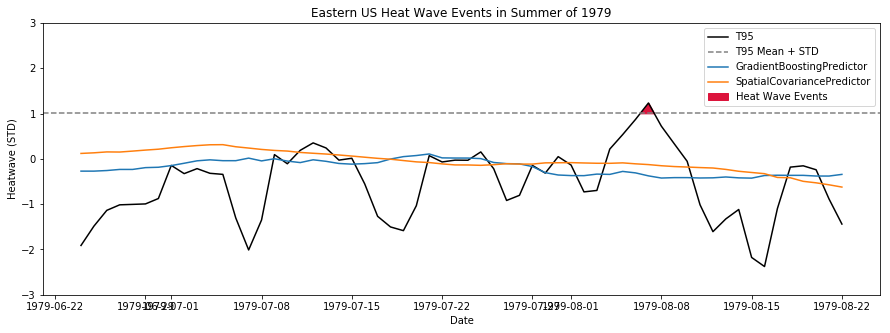

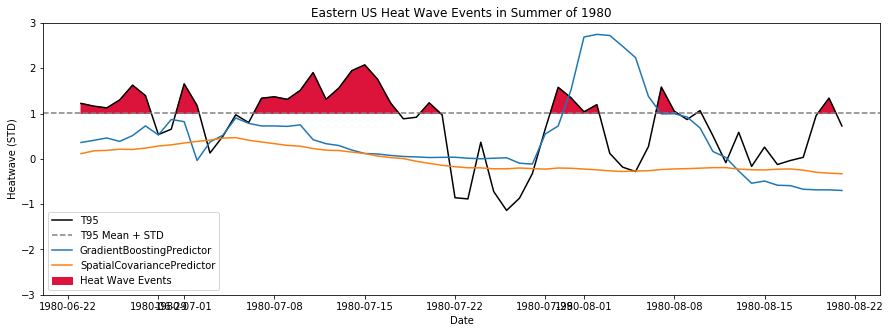

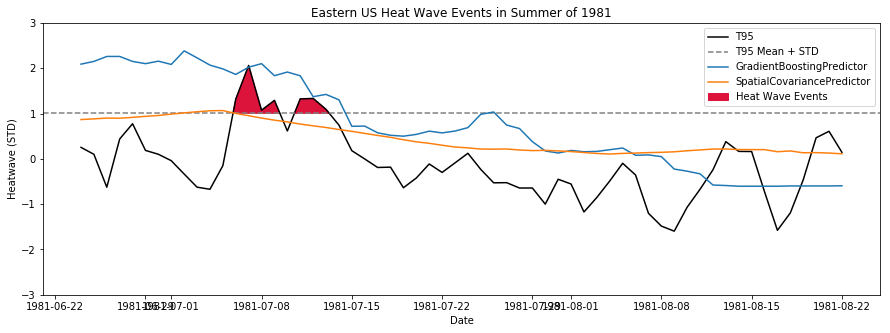

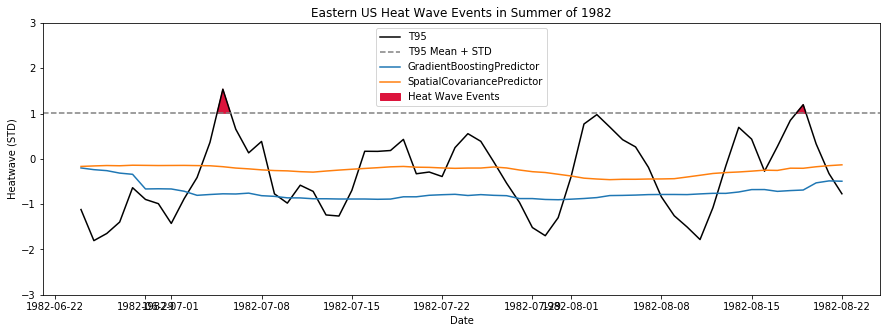

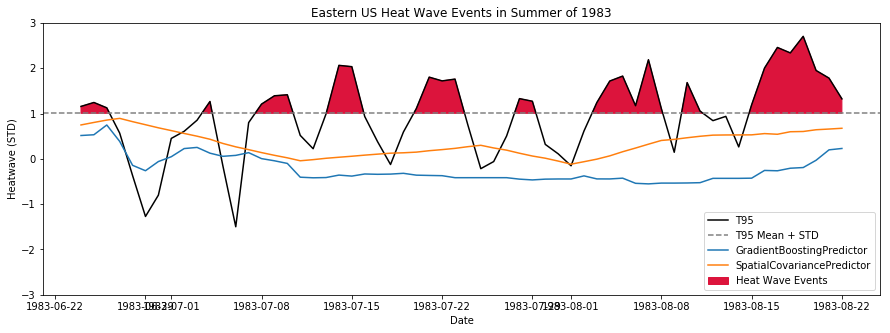

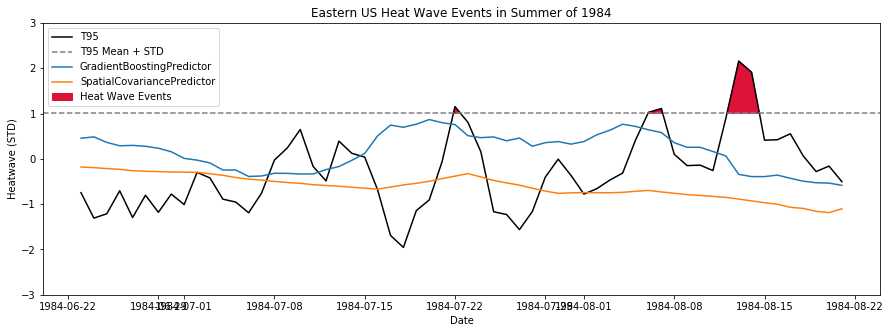

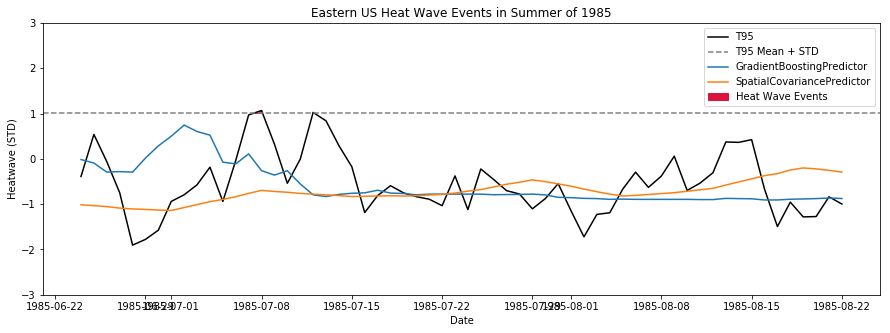

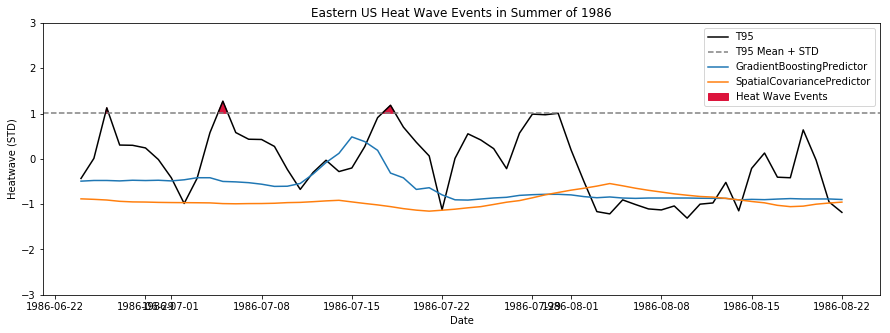

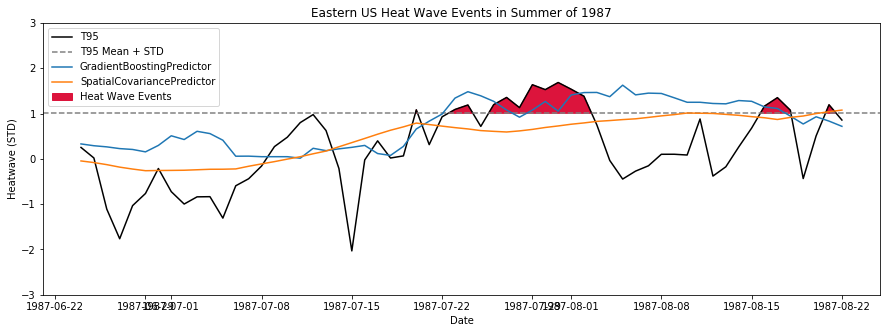

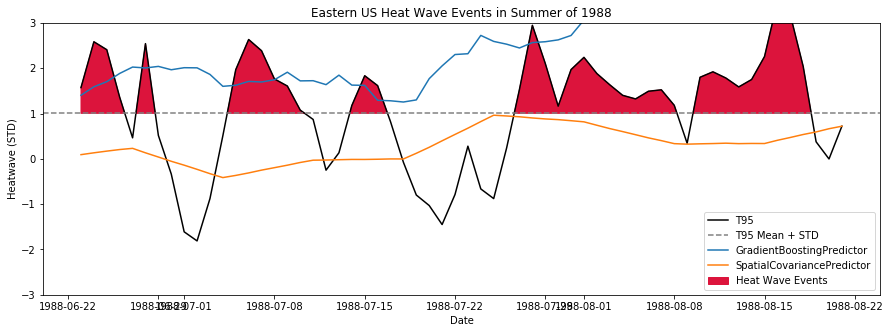

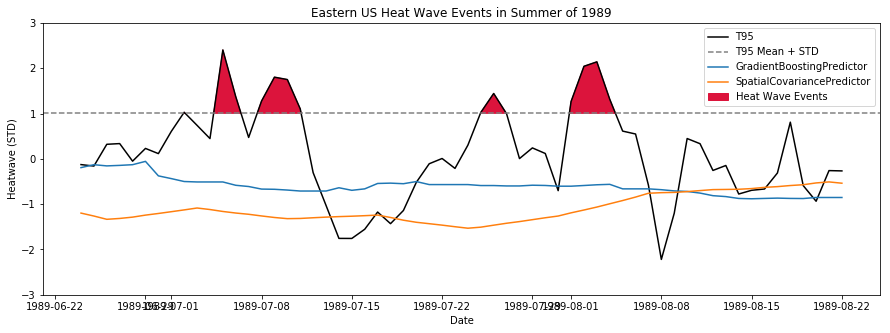

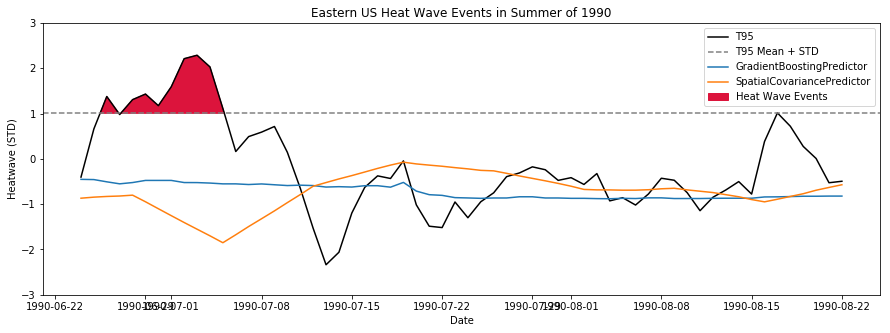

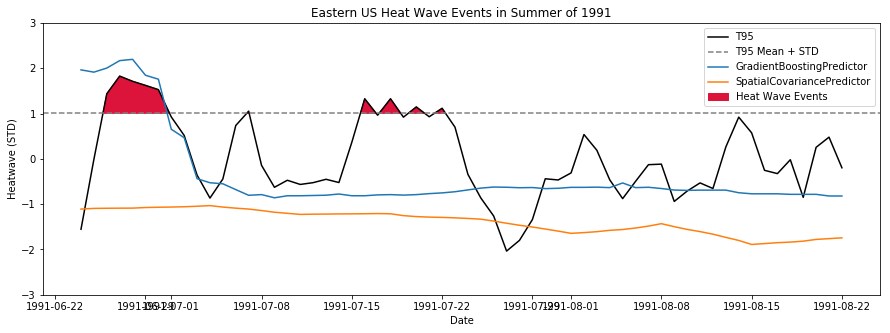

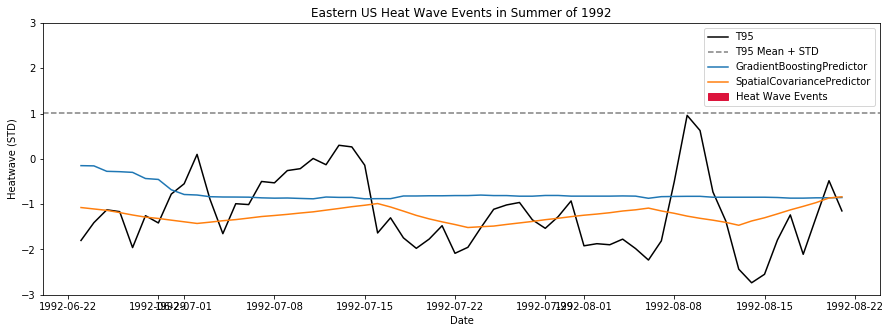

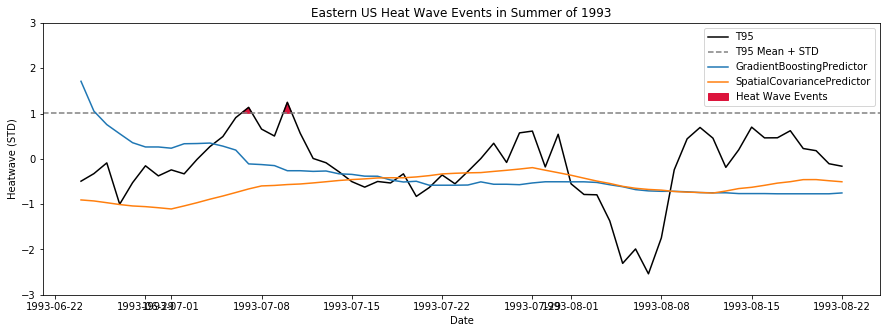

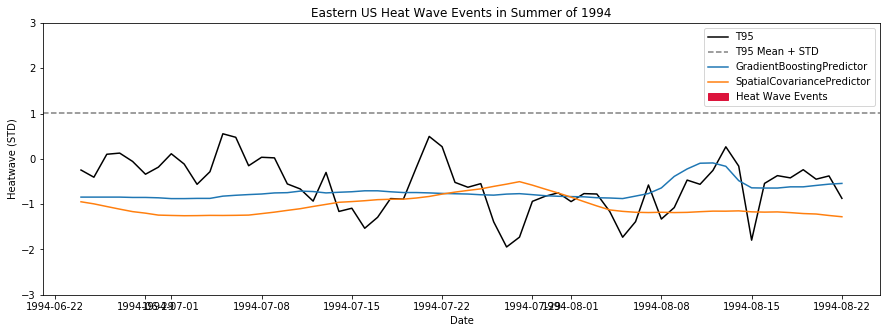

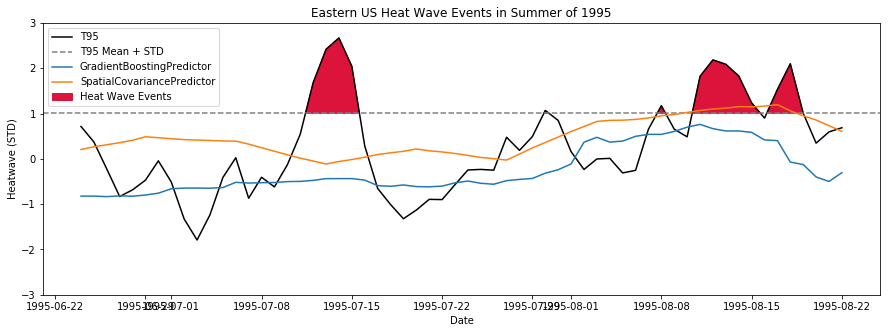

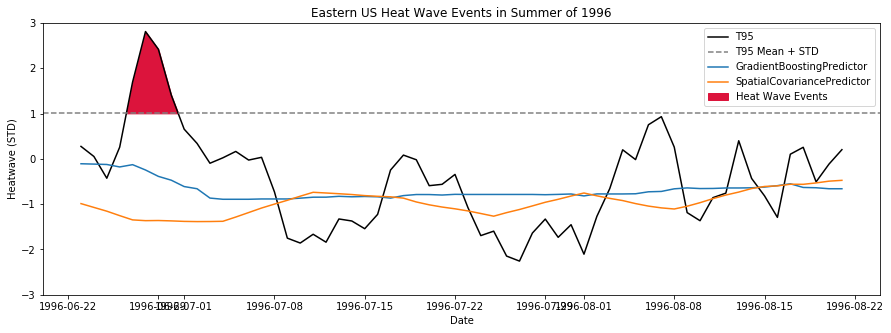

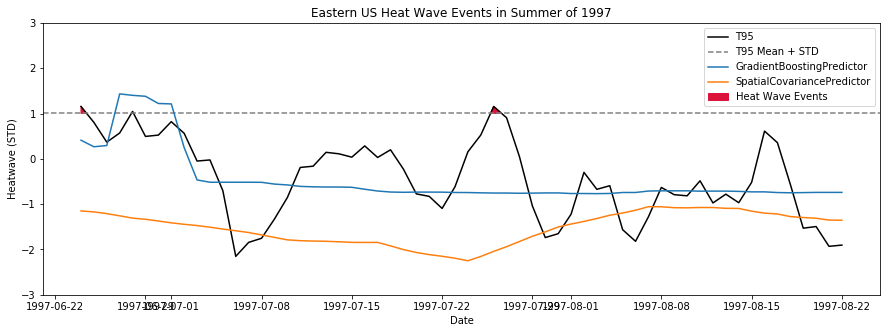

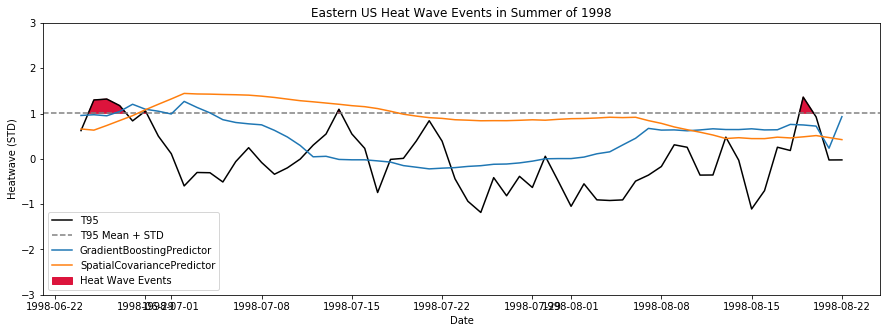

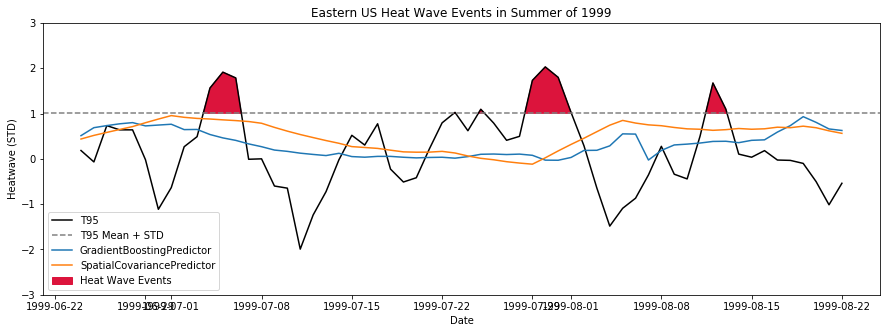

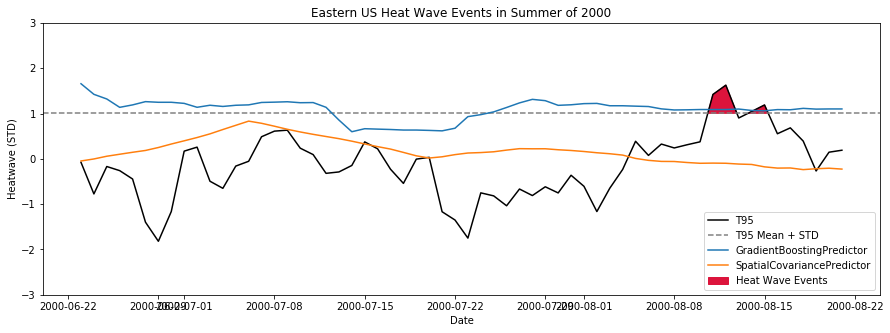

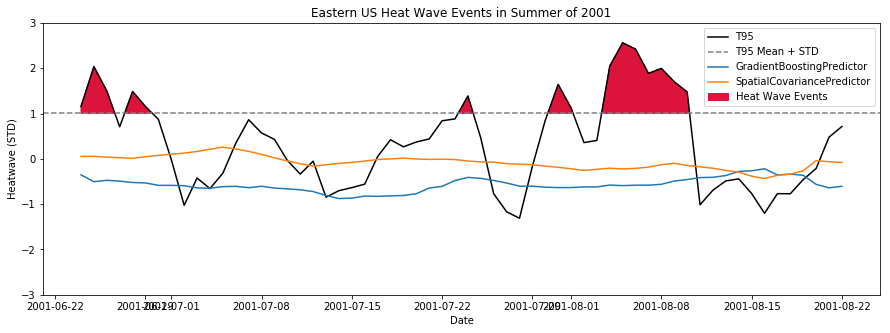

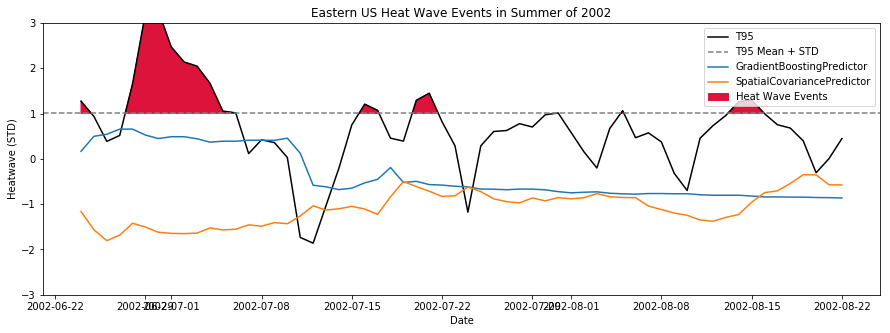

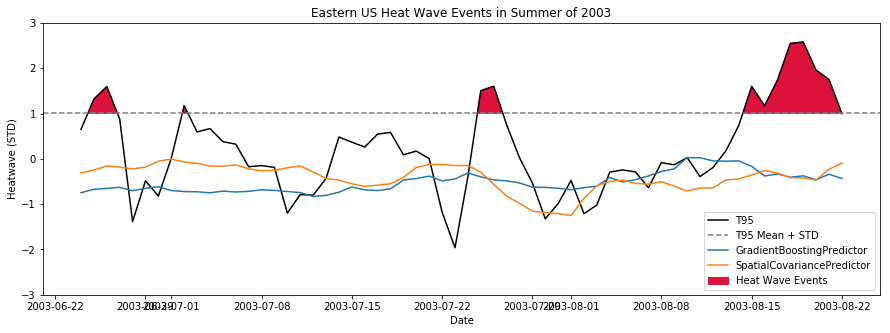

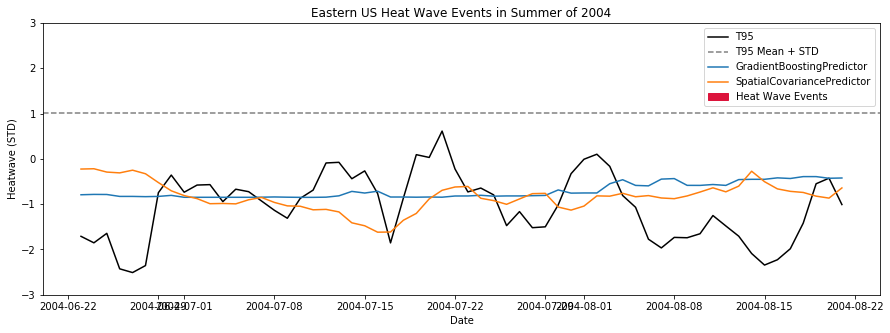

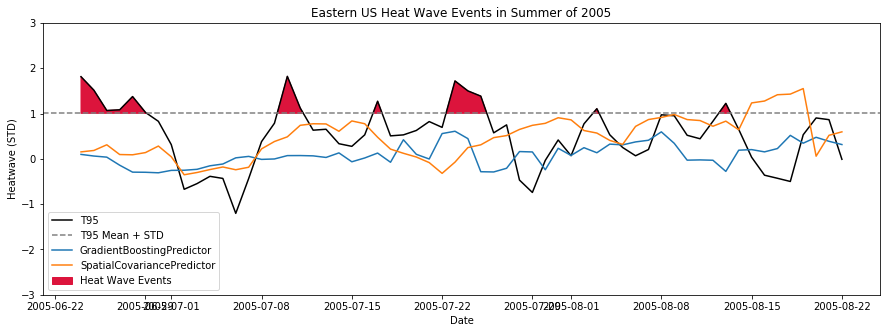

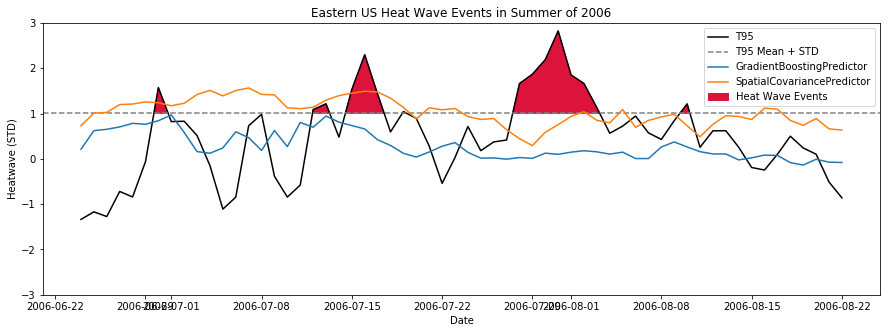

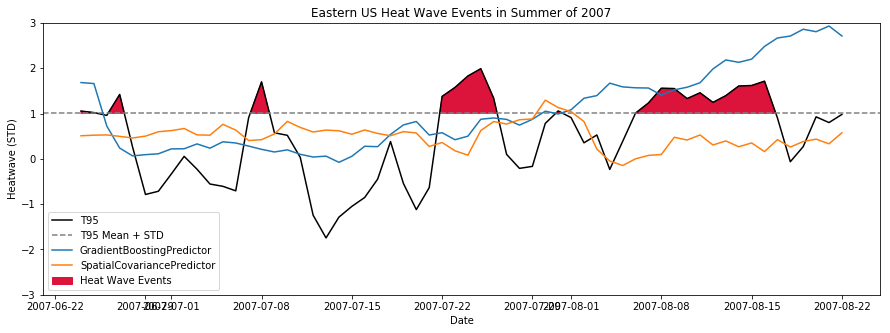

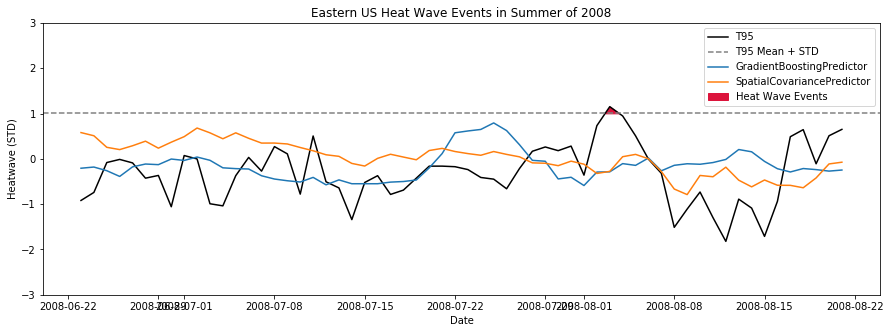

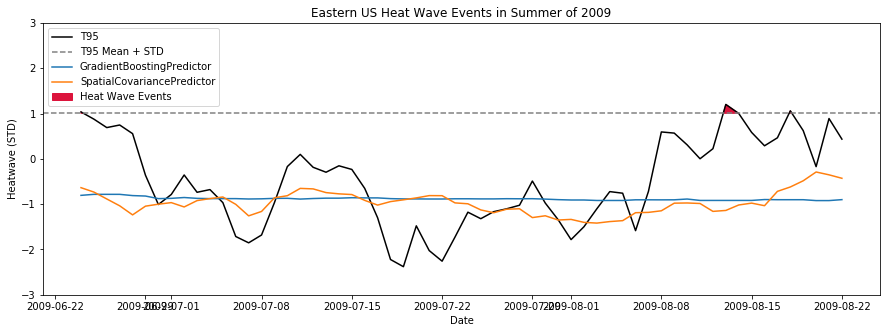

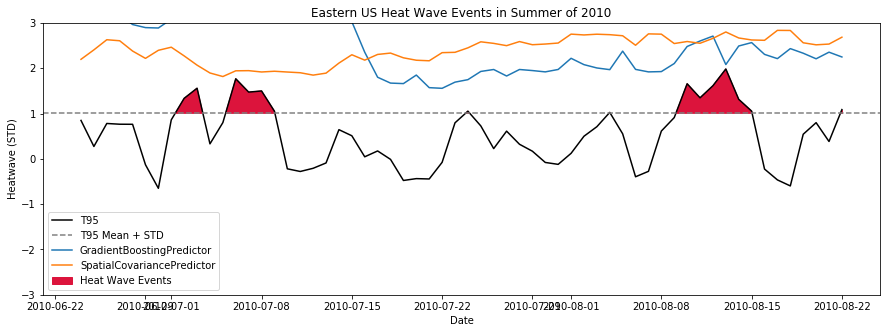

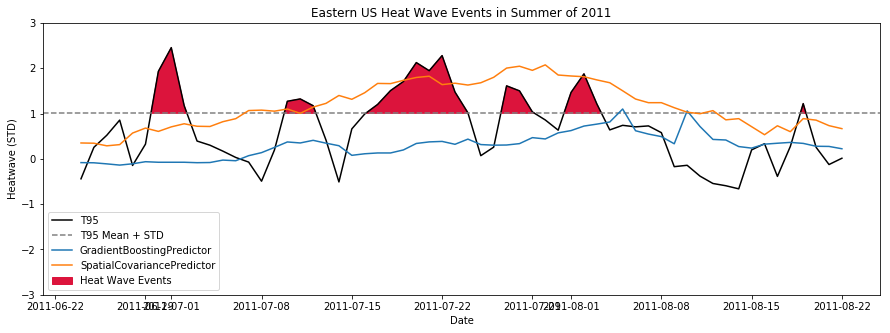

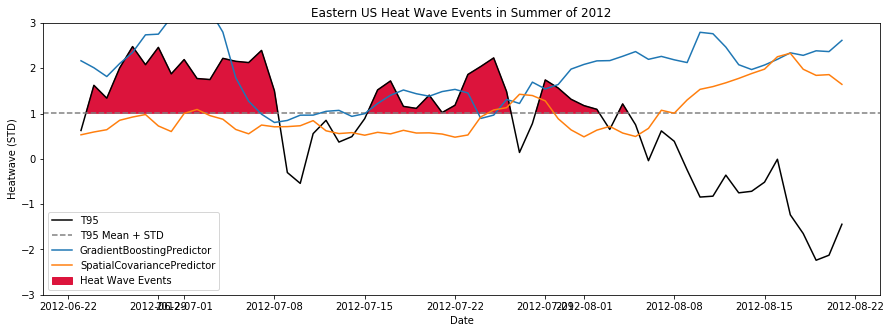

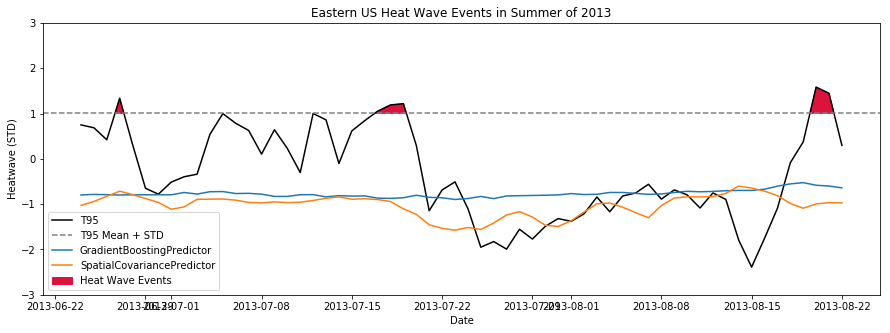

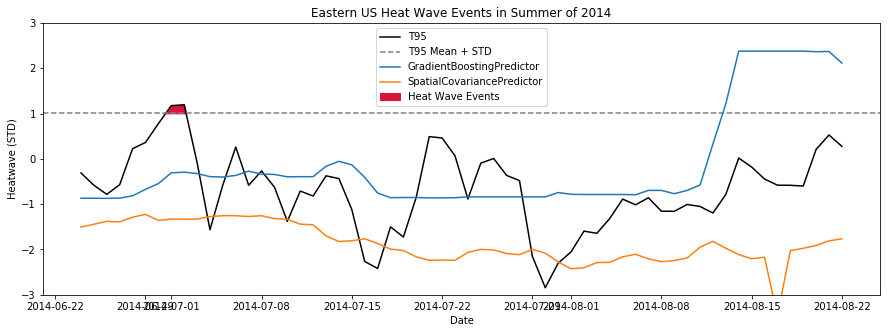

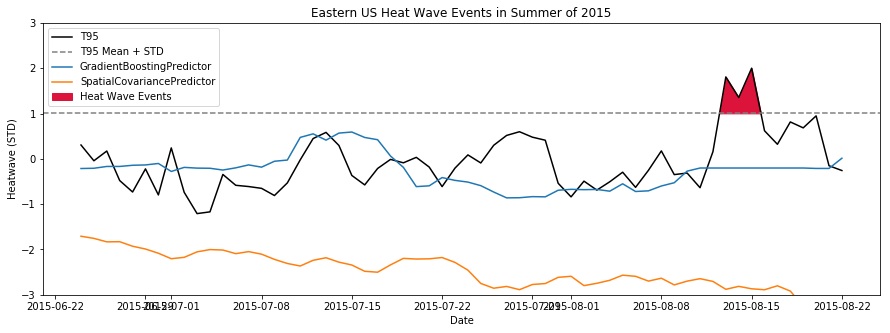

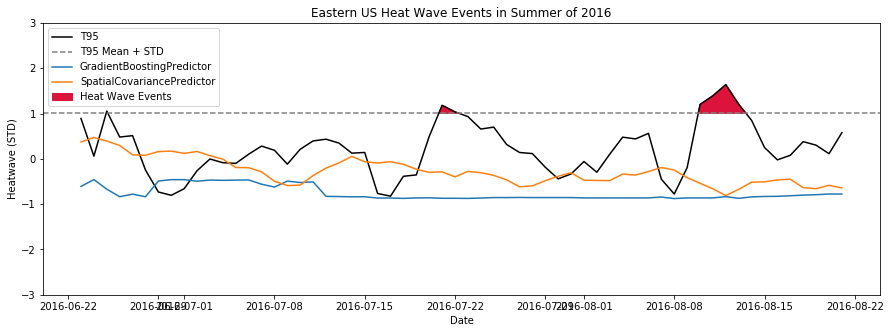

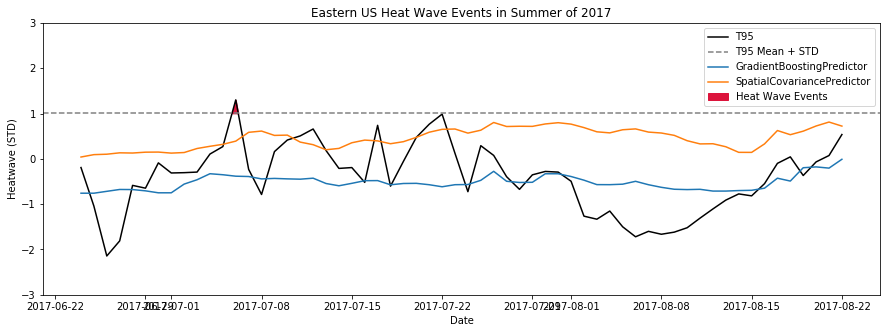

In [457]:
labels = Labels()

for YEAR in labels.years:
    labels.plot(YEAR)
    predictor_gbmt.plot(YEAR)
    predictor_spatcov.plot(YEAR)
    plt.legend()
    plt.show()